In [191]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from matplotlib import cm
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import MNIST,FashionMNIST
#from visualization14 import ANN
#%matplotlib widget

In [192]:
# Synthetic dataset
from sklearn.datasets import make_classification
# Data processing
import pandas as pd
import numpy as np
from collections import Counter
# Visualization
import matplotlib.pyplot as plt
# Model and performance
from sklearn.svm import OneClassSVM
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import copy

## For trained weights

In [193]:
import numpy as np
import pytorch_lightning as pl
import torch
from pytorch_lightning.callbacks import Callback, ModelCheckpoint
from pytorch_lightning.metrics.functional import accuracy
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader, random_split
from torchvision import transforms
from torchvision.datasets import MNIST


class EmbeddingsCallback(Callback):
    def __init__(self):
        super().__init__()
        
    def on_test_end(self, trainer, pl_module):
        #pl_module.
        trainer.logger.experiment.add_embedding(
            pl_module.test_embeddings,#pl_module.
            pl_module.test_targets,
            global_step=trainer.global_step)
        


class ANN(pl.LightningModule):
    def __init__(self,dataset_val1, data_dir='./'):
        super().__init__()
        # Set our init args as class attributes
        self.data_dir = data_dir
        self.test_targets = []
        self.test_embeddings = torch.zeros((0, 50),
                                           dtype=torch.float32,
                                           device='cpu')
        self.test_predictions = []
        
        self.dataset_train=[]
        self.dataset_val=dataset_val1
        # Hardcode some dataset specific attributes
        self.num_classes = 10
        self.dims = (1, 28, 28)
        self.transform = transforms.Compose([transforms.ToTensor()])
        self.conv1 = nn.Conv2d(1, 32, 3)
        self.bn1 = nn.BatchNorm2d(32)
        self.maxpool1 = nn.MaxPool2d(2)
        
        self.conv2 = nn.Conv2d(32, 64, 3)
        self.bn2 = nn.BatchNorm2d(64)
        self.maxpool2 = nn.MaxPool2d(2)
        
        self.conv3 = nn.Conv2d(64, 128, 3)
        self.bn3 = nn.BatchNorm2d(128)
        self.maxpool3 = nn.MaxPool2d(2)
        
        self.fc1 = nn.Linear(64 * 5 * 5, 128)
        self.fc2 = nn.Linear(128,50)
        self.fc3 = nn.Linear(50, self.num_classes)
        # Define PyTorch model

    def forward(self, x):
        batch_size,channles,width,highet= x.size()
        
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.maxpool1(x))
        
        batch_size,channles,width,highet= x.size()
        
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.maxpool2(x))
        
        batch_size,channles,width,highet= x.size()
        
        x = x.view(-1, 64 * 5 *5)
        x = self.fc1(x)
        x = self.fc2(x)
        y = self.fc3(F.relu(x))
        return x, y

    def training_step(self, batch, batch_idx):
        x, y = batch
        _, logits = self(x)
        loss = F.cross_entropy(logits, y)
        preds = torch.argmax(logits, dim=1)
        acc = accuracy(preds, y)
        self.log('train_loss', loss, prog_bar=True)
        self.log('train_acc', acc, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        _, logits = self(x)
        loss = F.cross_entropy(logits, y)
        preds = torch.argmax(logits, dim=1)
        acc = accuracy(preds, y)
        self.log('val_loss', loss, prog_bar=True)
        self.log('val_acc', acc, prog_bar=True)
        
        return loss

    def test_step(self, batch, batch_idx):
        # Here we just reuse the validation_step for testing
        x, y = batch
        embeddings, logits = self(x)
        loss = F.cross_entropy(logits, y)
        preds = torch.argmax(logits, dim=1)
        acc = accuracy(preds, y)
        self.test_predictions.extend(preds.detach().cpu().tolist())
        self.test_targets.extend(y.detach().cpu().tolist())
        self.test_embeddings = torch.cat((self.test_embeddings, embeddings), 0)
        self.log('test_acc', acc)
        self.log('test_loss', loss)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters())
        return optimizer

    ####################
    # DATA RELATED HOOKS
    ####################

    def prepare_data(self):
        # download
        print('')

    def setup(self, dataset_train1,dataset_test1=[],dataset_val1=[], stage=None):

        # Assign train/val datasets for use in dataloaders
        if stage == 'fit':
            self.dataset_train, self.dataset_val,self.dataset_test=dataset_train1,dataset_val1,dataset_test1
           
        print(len(self.dataset_train))
        if stage == 'test':
            self.dataset_test = dataset_test1
                                  

    def train_dataloader(self):
        return DataLoader(self.dataset_train, batch_size=32, shuffle=True)

    def val_dataloader(self):
        return DataLoader(self.dataset_val, batch_size=32)

    def test_dataloader(self):
        return DataLoader(self.dataset_test, batch_size=32)


In [194]:
if __name__ == "__main__":
    
    data_dir='./'
    # download
    MNIST(data_dir, train=True, download=True)
    MNIST(data_dir, train=False, download=True)
    transform = transforms.Compose([transforms.ToTensor()])
    dataset_full = MNIST(data_dir,train=True,transform=transform)
            
    dataset_train, dataset_val,remaining = random_split(dataset_full, [200, 10000,49800])
    dataset_train_original=copy.deepcopy(dataset_train)


    model = ANN(dataset_val)
    model.setup(dataset_train,dataset_val,stage='fit')
    model.dataset_val=dataset_val
    embedding_callback = EmbeddingsCallback()
    checkpoint_callback = ModelCheckpoint(
        monitor='val_loss',
        filename='mnist-{epoch:02d}-{val_loss:.2f}',
        save_top_k=3,
        save_weights_only=True)
    trainer = pl.Trainer(
                         max_epochs=100,
                         progress_bar_refresh_rate=10,
                         callbacks=[checkpoint_callback, embedding_callback])#gpus=1,
    trainer.fit(model)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores


200

200



   | Name     | Type        | Params
------------------------------------------
0  | conv1    | Conv2d      | 320   
1  | bn1      | BatchNorm2d | 64    
2  | maxpool1 | MaxPool2d   | 0     
3  | conv2    | Conv2d      | 18.5 K
4  | bn2      | BatchNorm2d | 128   
5  | maxpool2 | MaxPool2d   | 0     
6  | conv3    | Conv2d      | 73.9 K
7  | bn3      | BatchNorm2d | 256   
8  | maxpool3 | MaxPool2d   | 0     
9  | fc1      | Linear      | 204 K 
10 | fc2      | Linear      | 6.5 K 
11 | fc3      | Linear      | 510   
------------------------------------------
305 K     Trainable params
0         Non-trainable params
305 K     Total params
1.220     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

## Shows some of MNIST data

In [195]:
import itertools
batch_size = 2
sample_at = 5
k = int(np.floor(sample_at/batch_size))

tensor([0, 1, 8, 9, 1, 1, 8, 2, 2, 5, 6, 3, 7, 4, 4, 9, 2, 1, 7, 6, 4, 2, 5, 1,
        0, 8, 6, 5, 4, 6, 8, 8])


C:\Users\USER\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:43: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  result = getattr(asarray(obj), method)(*args, **kwds)
C:\Users\USER\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = getattr(asarray(obj), method)(*args, **kwds)


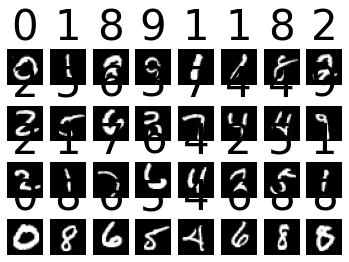

In [196]:
import itertools
k = int(np.floor(sample_at/batch_size))
transform = transforms.Compose([transforms.ToTensor()])
#data = MNIST(".", train=False, download=True, transform=transform)
data=copy.deepcopy(dataset_train)
dataloader = DataLoader(data, batch_size=32)
my_sample = next(itertools.islice(dataloader, k, None))
print (my_sample[1])

plt.figure()
for i in range(32):
    plt.subplot(4,8,i+1)
    arr=np.squeeze(data)
    plt.imshow(my_sample[0][i][0], cmap='gray')
    plt.axis('off')
    plt.title(my_sample[1][i].item())

#dataloader = DataLoader(data, batch_size=32)

## prepare_test_embeddings

In [197]:
def prepare_test_embeddings(dataset_train):
    #transform = transforms.Compose([transforms.ToTensor()])
    #data=dataset_train
    dataloader = DataLoader(dataset_train, batch_size=32)
    #test_imgs = torch.zeros((0, 1, 28, 28), dtype=torch.float32)
    test_predictions = []
    test_targets = []
    test_embeddings = torch.zeros((0, 50), dtype=torch.float32)
    for x,y in dataloader:
        #x = x.cpu()
        embeddings, logits = model(x)
        preds = torch.argmax(logits, dim=1)
        test_predictions.extend(preds.detach().cpu().tolist())
        test_targets.extend(y.detach().cpu().tolist())
        test_embeddings = torch.cat((test_embeddings, embeddings.detach().cpu()), 0)
        #test_imgs = torch.cat((test_imgs, x.detach().cpu()), 0)
    #test_imgs = np.array(test_imgs)
    test_embeddings = np.array(test_embeddings)
    test_targets = np.array(test_targets)
    test_predictions = np.array(test_predictions)
    
    test_acc = np.sum(test_predictions == test_targets)
    final_test_acc = test_acc/len(test_embeddings)
    
    return test_embeddings,test_targets,test_predictions,final_test_acc
#test_embeddings,test_targets,final_test_acc=prepare_test_embeddings(dataset_train)

In [198]:
data_test = MNIST(".", train=False, download=True, transform=transform)
_,_,_,final_test_acc=prepare_test_embeddings(data_test)
print('Initial Testing accuracy:  ',final_test_acc)

Initial Testing accuracy:   0.8813


# Kmeans ++

In [199]:
def all_list(test_embeddings,test_targets,data):
    test_embeddings=test_embeddings
    test_targets=test_targets
    list1,data1=[],[]
    list2,data2=[],[]
    list3,data3=[],[]
    list4,data4=[],[]
    list5,data5=[],[]
    list6,data6=[],[]
    list7,data7=[],[]
    list8,data8=[],[]
    list9,data9=[],[]
    list10,data10=[],[]
    i=0
    for embeddings in test_embeddings:
        if test_targets[i]==0:
            list1.append(embeddings)
            data1.append(data[i])
        if test_targets[i]==1:
            list2.append(embeddings)
            data2.append(data[i])
        if test_targets[i]==2:
            list3.append(embeddings)
            data3.append(data[i])
        if test_targets[i]==3:
            list4.append(embeddings)
            data4.append(data[i])
        if test_targets[i]==4:
            list5.append(embeddings)
            data5.append(data[i])
        if test_targets[i]==5:
            list6.append(embeddings)
            data6.append(data[i])
        if test_targets[i]==6:
            list7.append(embeddings)
            data7.append(data[i])
        if test_targets[i]==7:
            list8.append(embeddings)
            data8.append(data[i])
        if test_targets[i]==8:
            list9.append(embeddings)
            data9.append(data[i])
        if test_targets[i]==9:
            list10.append(embeddings)
            data10.append(data[i])
        i=i+1
    all_lists=[]
    all_data=[]
    list1,data1=np.array(list1),np.array(data1)
    all_lists.append(list1),all_data.append(data1)
    
    list2,data2=np.array(list2),np.array(data2)
    all_lists.append(list2),all_data.append(data2)
    
    list3,data3=np.array(list3),np.array(data3)
    all_lists.append(list3),all_data.append(data3)
    
    list4,data4=np.array(list4),np.array(data4)
    all_lists.append(list4),all_data.append(data4)
    
    list5,data5=np.array(list5),np.array(data5)
    all_lists.append(list5),all_data.append(data5)
    
    list6,data6=np.array(list6),np.array(data6)
    all_lists.append(list6),all_data.append(data6)
    
    list7,data7=np.array(list7),np.array(data7)
    all_lists.append(list7),all_data.append(data7)
    
    list8,data8=np.array(list8),np.array(data8)
    all_lists.append(list8),all_data.append(data8)
    
    list9,data9=np.array(list9),np.array(data9)
    all_lists.append(list9),all_data.append(data9)
    
    list10,data10=np.array(list10),np.array(data10)
    all_lists.append(list10),all_data.append(data10)
    
    print(list10.shape, len(list9),len(all_lists))
    return all_lists,all_data
#all_lists=all_list(test_embeddings2,test_targets2)
#all_lists=all_list(all_np,labels)

Prepare test embeddings for all data  

# extract embeddings of 200 training data to get the center points

In [200]:
len(dataset_train)

200

In [201]:
dataset_full2, remaning = random_split(dataset_train, [len(dataset_train),0])

In [202]:
test_embeddings,test_targets,test_predictions,final_test_acc=prepare_test_embeddings(dataset_train)

In [203]:
temb_test_embeddings_copy=test_embeddings
dataset_full2_copy=dataset_full2
test_targets_copy=test_targets
test_predictions_copy=test_predictions

# visualize the ditribution of Random 200 points 

# To Get only the correct data prediction  

In [204]:
def get_correct_embeddings(temb_test_embeddings_copy,dataset_full2_copy,test_targets_copy,test_predictions_copy):
    c=0
    print(len(temb_test_embeddings_copy))
    for i in range(len(temb_test_embeddings_copy)):
        try:
            if test_targets_copy[i]!=test_predictions_copy[i]:
                print(i)
                temb_test_embeddings_copy=np.delete(temb_test_embeddings_copy,i-c,axis=0)
                dataset_full2_copy=np.delete(dataset_full2_copy,i-c,axis=0)
                test_targets_copy=np.delete(test_targets_copy,i-c,axis=0)
                test_predictions_copy=np.delete(test_predictions_copy,i-c,axis=0)
                c=c+1
        except:
            print("")
    print(len(temb_test_embeddings_copy))
    return temb_test_embeddings_copy,dataset_full2_copy,test_targets_copy,test_predictions_copy
print(len(temb_test_embeddings_copy))

200


In [205]:
test_embeddings=temb_test_embeddings_copy
dataset_full2=dataset_full2_copy
test_targets=test_targets_copy
dataset_train_original2=dataset_full2

In [206]:
all_lists,all_data_points=all_list(test_embeddings,test_targets,dataset_full2)

(23, 50) 27 10


<ipython-input-199-3f24519255a4>:49: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  list1,data1=np.array(list1),np.array(data1)
<ipython-input-199-3f24519255a4>:49: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  list1,data1=np.array(list1),np.array(data1)
<ipython-input-199-3f24519255a4>:52: FutureWarning: The input object of type 'Tensor' is an array-like implementin

In [207]:
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin_min

In [208]:
kmeans = KMeans(n_clusters = 10)
kmeans.fit(test_embeddings) 
kmeans.labels_

array([1, 1, 5, 3, 0, 6, 8, 0, 8, 1, 3, 5, 5, 8, 4, 9, 1, 8, 8, 2, 5, 7,
       5, 5, 5, 4, 0, 8, 3, 4, 0, 9, 9, 4, 2, 8, 9, 6, 4, 3, 0, 6, 1, 8,
       4, 2, 9, 0, 5, 9, 0, 6, 7, 9, 9, 0, 1, 0, 0, 5, 9, 7, 4, 1, 6, 5,
       0, 8, 5, 5, 0, 2, 2, 7, 4, 9, 3, 1, 1, 8, 2, 5, 3, 4, 1, 2, 7, 5,
       6, 0, 4, 7, 1, 4, 0, 0, 7, 4, 7, 5, 1, 0, 5, 8, 5, 8, 5, 4, 2, 4,
       2, 5, 3, 3, 3, 5, 1, 6, 1, 1, 1, 1, 2, 8, 7, 2, 1, 9, 6, 9, 6, 0,
       0, 3, 3, 2, 4, 6, 1, 8, 6, 0, 3, 3, 0, 1, 2, 3, 1, 9, 3, 1, 6, 0,
       5, 0, 5, 7, 8, 9, 8, 0, 0, 4, 1, 8, 5, 6, 8, 1, 3, 4, 1, 3, 1, 9,
       6, 4, 6, 5, 7, 9, 8, 3, 8, 8, 0, 8, 5, 5, 6, 0, 0, 5, 5, 3, 3, 8,
       6, 6])

In [209]:
len(kmeans.cluster_centers_)

10

In [210]:
all_clusters=kmeans.cluster_centers_

In [211]:
import math
import scipy.spatial as sp
import numpy as np
def get_dist(a,b):
    reslt=sp.distance.cosine(a,b)
    return reslt

In [212]:
len(test_embeddings)

200

# assign center point for each class 

In [213]:
center_classes=[]
for clas in all_lists:
    for cluster in all_clusters:
        p=cluster
        n = len(clas)
        dist = math.inf #(infinity)
        temb_test_embeddings=clas#.copy()
        for i in range(n):
            d = get_dist(p,temb_test_embeddings[i])
            if d<dist and d!=0: # to avoid the same point
                dist =d
                np1= temb_test_embeddings[i]
    center_classes.append(np1)
    indx=np.where(all_clusters==cluster)
    all_clusters=np.delete(all_clusters,indx[0][0],axis=0)
    print(len(all_clusters))
len(center_classes)

9
8
7
6
5
4
3
2
1
0


10

# get 10 neighbours for each class to perform (200 initial points)

In [214]:
points_class0=[]
points_class1=[]
points_class2=[]
points_class3=[]
points_class4=[]
points_class5=[]
points_class6=[]
points_class7=[]
points_class8=[]
points_class9=[]
all_points=[]
all_points.append(points_class0)
all_points.append(points_class1)
all_points.append(points_class2)
all_points.append(points_class3)
all_points.append(points_class4)
all_points.append(points_class5)
all_points.append(points_class6)
all_points.append(points_class7)
all_points.append(points_class8)
all_points.append(points_class9)


points_dist0=[]
points_dist1=[]
points_dist2=[]
points_dist3=[]
points_dist4=[]
points_dist5=[]
points_dist6=[]
points_dist7=[]
points_dist8=[]
points_dist9=[]
all_dist=[]
all_dist.append(points_dist0)
all_dist.append(points_dist1)
all_dist.append(points_dist2)
all_dist.append(points_dist3)
all_dist.append(points_dist4)
all_dist.append(points_dist5)
all_dist.append(points_dist6)
all_dist.append(points_dist7)
all_dist.append(points_dist8)
all_dist.append(points_dist9)

In [215]:
all_np=[]
all_others=[]
for lab in range(10):
    p=center_classes[lab]
    n = len(all_lists[lab])
    dist = math.inf #(infinity)
    temb_test_embeddings=all_lists[lab]#kmeans.labels_
    for c in range(10): 
        n = len(temb_test_embeddings)
        dist = math.inf
        for i in range(n):
            d = get_dist(p,temb_test_embeddings[i])
            if d<dist and d!=0: # to avoid the same point
                dist =d
                np1= temb_test_embeddings[i]
            else:
                np2= temb_test_embeddings[i]
        all_np.append(np1)
        all_others.append(np2)
        indx=np.where(temb_test_embeddings==np1)
        print(len(temb_test_embeddings))
        
        temb_test_embeddings=np.delete(temb_test_embeddings,indx[0][0],axis=0)
        dataset_train_original2=np.delete(dataset_train_original2,indx[0][0],axis=0)
        
        
    n = len(temb_test_embeddings)
    dist = math.inf
    for i in range(n):
        d = get_dist(p,temb_test_embeddings[i])
        all_points[lab].append(all_data_points[lab][i])
        all_dist[lab].append(d)
len(all_np),len(all_others)

18
17
16
15
14
13
12
11
10
9
26
25
24
23
22
21
20
19
18
17
14
13
12
11
10
9
8
7
6
5
16
15
14
13
12
11
10
9
8
7
26
25

C:\Users\USER\anaconda3\lib\site-packages\numpy\lib\function_base.py:5030: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  arr = asarray(arr)
C:\Users\USER\anaconda3\lib\site-packages\numpy\lib\function_base.py:5030: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asarray(arr)



24
23
22
21
20
19
18
17
12
11
10
9
8
7
6
5
4
3
18
17
16
15
14
13
12
11
10
9
20
19
18
17
16
15
14
13
12
11
27
26
25
24
23
22
21
20
19
18
23
22
21
20
19
18
17
16
15
14


(100, 100)

# get the original images (as core_data) corrosponding to the 100 center points

In [216]:
indx=np.where(test_embeddings==all_np[0])
core_data1=dataset_full2[indx[0][0]]
core_data1,t=random_split([core_data1],[1,0])
core_data1=tuple(core_data1)
for point in all_np[1:]: 
    indx=np.where(test_embeddings==point)
    arr=dataset_full2[indx[0][0]]
    arr,t=random_split([arr],[1,0])
    arr=tuple(arr)
    core_data1=torch.utils.data.ConcatDataset([arr,core_data1])

In [217]:
core_data=core_data1
len(core_data)

100

# get the 100 other images 

In [218]:
indx=np.where(test_embeddings==all_others[0])
other_data1=dataset_full2[indx[0][0]]
other_data1,t=random_split([other_data1],[1,0])
other_data1=tuple(other_data1)
for point in all_others[1:]: 
    indx=np.where(test_embeddings==point)
    arr=dataset_full2[indx[0][0]]
    arr,t=random_split([arr],[1,0])
    arr=tuple(arr)
    other_data1=torch.utils.data.ConcatDataset([arr,other_data1])

In [219]:
len(other_data1)

100

# Embeddings of 100 core-set

In [220]:
test_embeddings_core,test_targets_core,test_predictions_core,final_test_acc2=prepare_test_embeddings(core_data)

# visualize the ditribution of 100 core_data 

### **For one class SVM**

In [221]:
all_lists,_=all_list(test_embeddings_core,test_targets_core,core_data)

(12, 50) 16 10


<ipython-input-199-3f24519255a4>:49: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  list1,data1=np.array(list1),np.array(data1)
<ipython-input-199-3f24519255a4>:49: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  list1,data1=np.array(list1),np.array(data1)
<ipython-input-199-3f24519255a4>:52: FutureWarning: The input object of type 'Tensor' is an array-like implementin

In [222]:
X_train=np.concatenate((all_lists[9],all_lists[8],all_lists[7],all_lists[6],all_lists[5],all_lists[4],all_lists[3],all_lists[2],all_lists[1],all_lists[0]),axis=0)
len(X_train)

100

In [223]:
# Train the one class support vector machine (SVM) model
one_class_svm = OneClassSVM(nu=0.05, kernel = 'rbf', gamma = 'scale').fit(X_train)

In [224]:
def do_predict(dataset_test):
    #transform = transforms.Compose([transforms.ToTensor()])
    #data=dataset_test#dataset_test
    dataloader = DataLoader(dataset_test, batch_size=32)
    #test_imgs = torch.zeros((0, 1, 28, 28), dtype=torch.float32)
    test_predictions = []
    test_targets = []
    test_embeddings = torch.zeros((0, 50), dtype=torch.float32)
    for x,y in dataloader:
        #x = x.cpu()
        embeddings, logits = model(x)
        preds = torch.argmax(logits, dim=1)
        test_predictions.extend(preds.detach().cpu().tolist())
        test_targets.extend(y.detach().cpu().tolist())
        test_embeddings = torch.cat((test_embeddings, embeddings.detach().cpu()), 0)
        #test_imgs = torch.cat((test_imgs, x.detach().cpu()), 0)
    #test_imgs = np.array(test_imgs)
    test_embeddings = np.array(test_embeddings)
    test_targets = np.array(test_targets)
    test_predictions = np.array(test_predictions)
    train_acc = np.sum(test_predictions == test_targets)
    final_train_acc = train_acc/len(test_embeddings)
    final_train_acc
    return final_train_acc,test_targets,test_embeddings

In [225]:
dataset_full2 = tuple([tuple(e) for e in dataset_full2])
len(dataset_full2)

200

# Just to visualize outlier prediction (Take the First 100 outlier points)

In [226]:
 _,_,test_embeddings=do_predict(remaining)
whole_prediction=one_class_svm.predict(test_embeddings)
Scores=one_class_svm.score_samples(test_embeddings)
len_out=0
for out1 in whole_prediction:
    if out1==1:
        len_out=len_out+1
print(len_out)
df_remaining=pd.DataFrame(np.array([Scores,remaining,list(test_embeddings)]).T,columns=['Score','Remaining','embeddings'])

45453


<ipython-input-226-8c662529fd3e>:9: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  df_remaining=pd.DataFrame(np.array([Scores,remaining,list(test_embeddings)]).T,columns=['Score','Remaining','embeddings'])


In [227]:
df_remaining.sort_values(by=['Score'], inplace=True,ascending=True)
Whole_outliers=torch.utils.data.ConcatDataset([[],[]])


for i in range(100):
    Whole_outliers=torch.utils.data.ConcatDataset([[(df_remaining['Remaining'][i][0],df_remaining['Remaining'][i][1])]
                                               ,Whole_outliers])
    indx=np.where(test_embeddings==df_remaining['embeddings'][i])
    remaining=np.delete(remaining,indx[0][0],axis=0)
remaining=tuple([tuple(e) for e in remaining])
remaining=torch.utils.data.ConcatDataset([remaining,[]])

dataset_train=torch.utils.data.ConcatDataset([Whole_outliers,dataset_train])
print('All Remaining',len(remaining))

C:\Users\USER\anaconda3\lib\site-packages\numpy\lib\function_base.py:5030: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  arr = asarray(arr)
C:\Users\USER\anaconda3\lib\site-packages\numpy\lib\function_base.py:5030: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asarray(arr)


All Remaining 49700


In [228]:
All_data_points=torch.utils.data.ConcatDataset([other_data1,core_data,Whole_outliers])
len(All_data_points)

300

In [229]:
_,target_All_points,embedding_All_points=do_predict(All_data_points)

In [230]:
tsne = TSNE(2, verbose=1)
tsne_proj_All_points = tsne.fit_transform(embedding_All_points)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 300 samples in 0.006s...
[t-SNE] Computed neighbors for 300 samples in 0.040s...
[t-SNE] Computed conditional probabilities for sample 300 / 300
[t-SNE] Mean sigma: 12.982408
[t-SNE] KL divergence after 250 iterations with early exaggeration: 59.659225
[t-SNE] KL divergence after 1000 iterations: 0.281841


In [231]:
prediction=np.concatenate([np.zeros(250),np.ones(50)])
#prediction

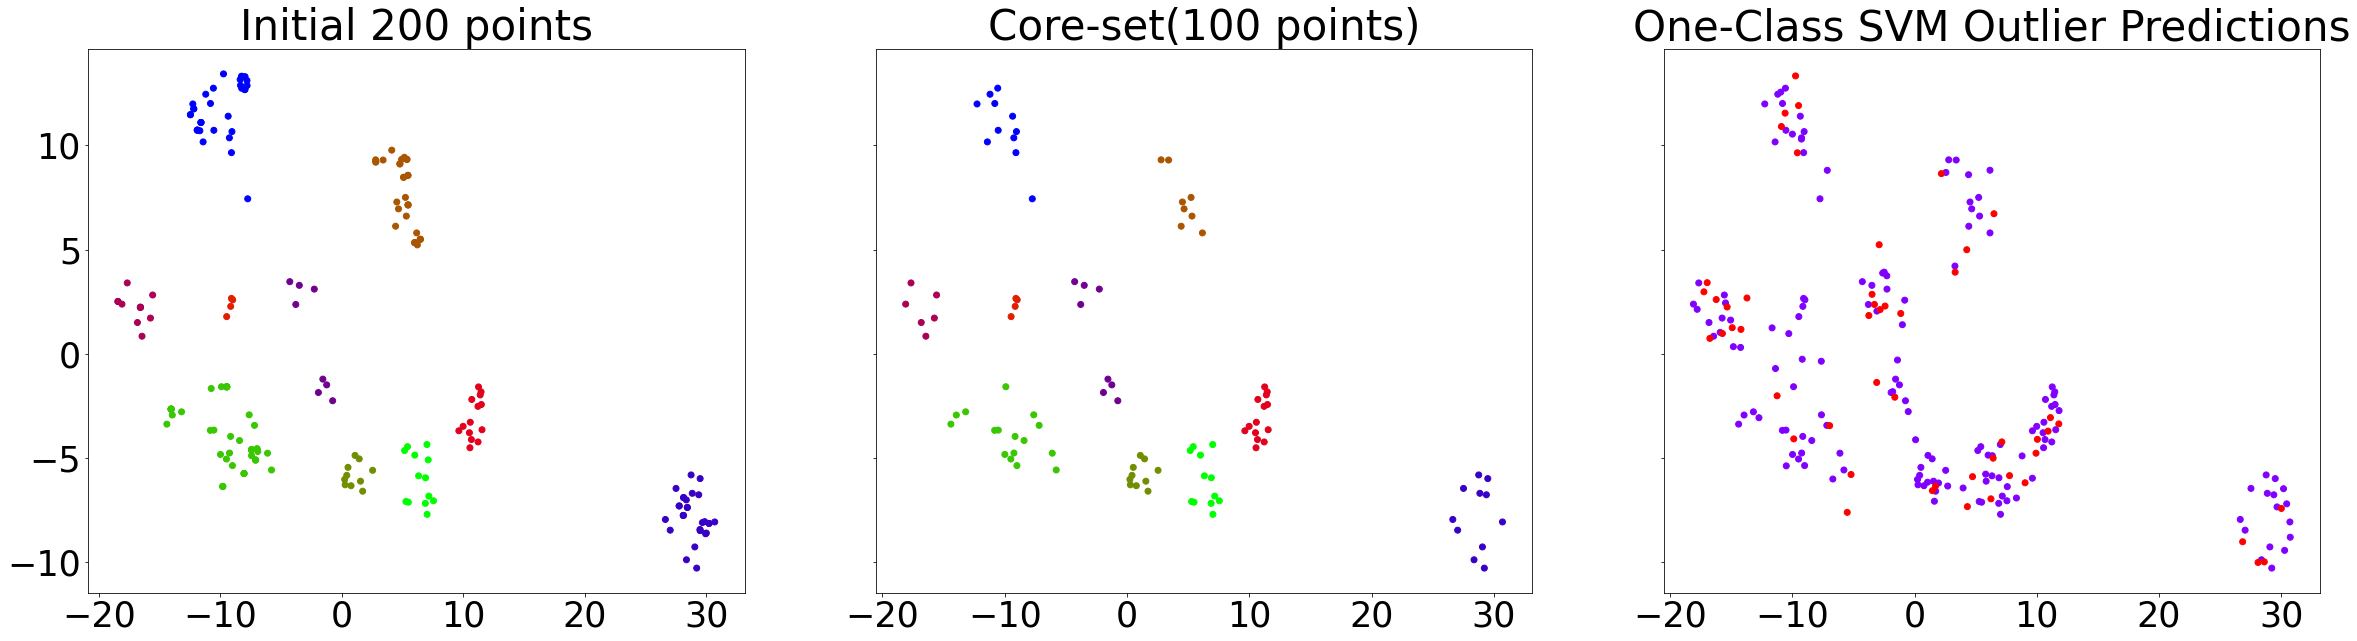

In [232]:
# Put the testing dataset and predictions in the same dataframe
plt.rcParams.update({'font.size': 35})
df_test = pd.DataFrame(tsne_proj_All_points, columns=['feature1', 'feature2'])
df_test['y_test'] = target_All_points#test_targets4
df_test['one_class_svm_prediction'] = prediction


#df_core = pd.DataFrame(tsne_proj_All_points, columns=['feature1', 'feature2'])
#df_core['y_test'] = target_All_points

fig, (ax0, ax1,ax2)=plt.subplots(1,3, sharey=True, figsize=(40,10))
# Ground truth
ax0.set_title('Initial 200 points')
ax0.scatter(df_test['feature1'][:200], df_test['feature2'][:200], c=df_test['y_test'][:200], cmap='brg')

ax1.set_title('Core-set(100 points)')
ax1.scatter(df_test['feature1'][100:200], df_test['feature2'][100:200], c=df_test['y_test'][100:200], cmap='brg')
# One-Class SVM Predictions
ax2.set_title('One-Class SVM Outlier Predictions')
ax2.scatter(df_test['feature1'][100:300], df_test['feature2'][100:300], c=df_test['one_class_svm_prediction'][100:300], cmap='rainbow')
